In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from plots import histogram
from loss import moment_matching_loss
from stock_price_handler import load_stock_prices, get_log_returns
from sde import BlackScholes

In [2]:
TIME_INCREMENT = 5
STOCK_NAME = "apple"

In [3]:
stock_prices = load_stock_prices(STOCK_NAME)
actual_log_returns = get_log_returns(stock_prices)

In [4]:
sigma = np.std(actual_log_returns) / np.sqrt(TIME_INCREMENT)
mu = np.mean(actual_log_returns) / TIME_INCREMENT + np.square(sigma) / 2
initial_states = torch.tensor(np.array(stock_prices))

In [5]:
black_scholes = BlackScholes(mu=mu, sigma=sigma, sample_size=len(stock_prices), times=torch.linspace(0, TIME_INCREMENT, TIME_INCREMENT))
optimizer = torch.optim.SGD(black_scholes.parameters(), lr=1e-4)

In [6]:
def train_loop(model, loss_function, optimizer, num_epochs):

    model.train()
    for epoch in range(num_epochs):

        estimated_log_returns = model(initial_states)
        loss = loss_function(estimated_log_returns, torch.tensor(actual_log_returns))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        print(f"Epoch {epoch}: Loss = {loss.item():>.7f}")
        if not epoch % 10 or epoch == num_epochs - 1:
            histogram(actual_log_returns, label="Actual", color="black")
            histogram(estimated_log_returns.detach().numpy(), label="Black Scholes", color="orange")
            plt.title(f"Epoch {epoch}: Loss = {loss.item():>.7f}")
            plt.legend()
            plt.show()


Epoch 0: Loss = 1.8128272


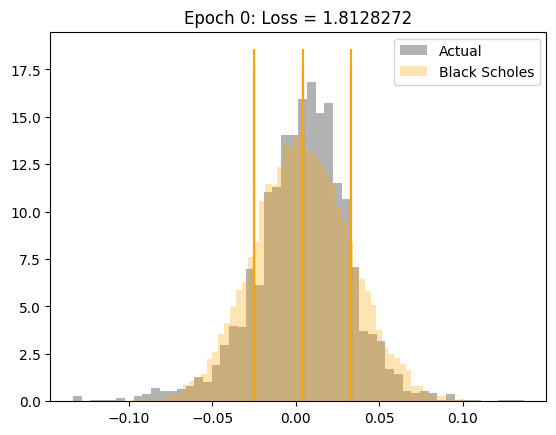

Epoch 1: Loss = 1.5025944
Epoch 2: Loss = 1.2272252
Epoch 3: Loss = 1.0109445
Epoch 4: Loss = 0.8658798
Epoch 5: Loss = 0.6400342
Epoch 6: Loss = nan
Epoch 7: Loss = nan
Epoch 8: Loss = nan


KeyboardInterrupt: 

In [7]:
train_loop(black_scholes, moment_matching_loss, optimizer, 50)